In [1]:
from tqdm import notebook
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os,re
from tqdm.notebook import tqdm,tnrange
from torchvision.transforms import PILToTensor, ToPILImage

from DatasetUtils.PlotUtils import plotResultsWithMasks, plotPairsWithMasks, plotLeafTimeSeries,plotExampleWithMasks
from DatasetUtils.DataParsing import leafDataset, findPairs_for_evaluation
from tracking.timeSeries import createMaskTimeSeries
from modelTraining.modelDefinition import get_instance_segmentation_model
from PIL import ImageDraw
from torchvision.transforms import ToPILImage
from cv2 import findContours, boundingRect, RETR_TREE, CHAIN_APPROX_SIMPLE

from tracking.pairing import *
import time

torch.cuda.get_device_name(0)

In [2]:
start =time.time()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model =get_instance_segmentation_model(2)
stateDict = torch.load("Models/Leaf_Segmentation_MaskedRCNN_7_7_2022_8h.h5",map_location=device)
model.load_state_dict(stateDict)
model.to(device)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

0it [00:00, ?it/s]

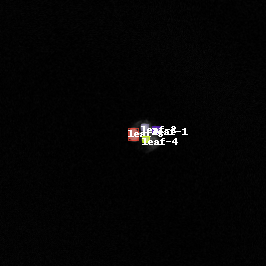

In [3]:
images = os.listdir(os.path.join(os.getcwd(),"Datasets/Mask_rcnn_validation_dataset/images"))
test_images = [os.path.join(os.getcwd(),"Datasets/Mask_rcnn_validation_dataset/images",e) for e in images]
test_json = [os.path.join(os.getcwd(),"Datasets/Mask_rcnn_validation_dataset/","Annotations",re.sub("\.png|\.jpg",".json",e)) for e in images]
testDataset = leafDataset(test_images,test_json)
testDataset.plotExampleWithMasks(np.random.randint(0,len(testDataset)))

In [4]:
if device.type == "cuda":
    results = []
    for i in tqdm(testDataset):
        i = torch.reshape(i[0],shape=(1,1,266,266))
        i = i.cuda()
        this_result = model(i)
        for idx,result in enumerate(this_result):
            for k,v in result.items():
                result[k] = v.detach().cpu()
            this_result[idx] = result
        results.append(this_result)
        del result
        del v
        del this_result
        del i
        torch.cuda.empty_cache()
else:
    results = []
    for i in tqdm(testDataset):
        this_result=model(i[0])
        results.append(this_result)

  0%|          | 0/53 [00:00<?, ?it/s]

In [10]:
for i in range(len(testDataset)):
    testDataset[i][1]["Category"] = re.sub(".*\\\\|_.*","",testDataset.ids_dict[i])

groundTruth = [e[1] for e in testDataset]
filtered_results = []
for e in results:
    temp_results = {
        "boxes":[],
        "labels":[],
        "scores":[],
        "masks":[]
    }
    for idx,val in enumerate(e[0]["scores"]):
        if val < 0.9:
            continue
        else:
            temp_results["boxes"].append(e[0]["boxes"][idx])
            temp_results["labels"].append(e[0]["labels"][idx])
            temp_results["scores"].append(e[0]["scores"][idx])
            temp_results["masks"].append(e[0]["masks"][idx][0])
    temp_results["boxes"] = torch.stack(temp_results["boxes"])
    temp_results["labels"] = torch.stack(temp_results["labels"])
    temp_results["scores"] = torch.stack(temp_results["scores"])
    temp_results["masks"] = torch.stack(temp_results["masks"])
    filtered_results.append(temp_results)

filtered_results

[{'boxes': tensor([[141.0433, 114.9017, 149.7623, 123.7267],
          [142.7038, 124.8751, 149.5935, 131.3422],
          [150.6519, 120.3560, 157.2195, 126.8122],
          [150.0880, 128.8460, 155.1114, 133.4964]]),
  'labels': tensor([1, 1, 1, 1]),
  'scores': tensor([0.9960, 0.9946, 0.9881, 0.9439]),
  'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],

In [11]:
all_pairs = []
all_notDetected = []
all_missDetection = []
for i in tnrange(len(groundTruth)):
    all_data = findPairs_for_evaluation(groundTruth[i],filtered_results[i])
    all_pairs.append(all_data[0])
    all_notDetected.append(all_data[1])
    all_missDetection.append(all_data[2])

  0%|          | 0/53 [00:00<?, ?it/s]

In [12]:
early = []
mid = []
late = []
for e in all_pairs:
    for j in e:
        if j["type"] == "Early":
            early.append(j["IoU"])
        elif j["type"] == "Late":
            late.append(j["IoU"])
        else:
            mid.append(j["IoU"])


In [17]:
df = pd.DataFrame([early,mid,late]).transpose()
df.columns = ["Early","Mid","Late"]
df.describe()

,Early,Mid,Late
count,65.000000,146.000000,294.000000
mean,0.725692,0.874481,0.860361
std,0.095111,0.098728,0.146970
min,0.509091,0.389262,0.198898
25%,0.676471,0.867584,0.863158
50%,0.728814,0.911357,0.910285
75%,0.800000,0.926885,0.932433
max,0.894231,0.961131,0.965956


In [16]:
earlyNotDetectedCounter = 0
midNotDetectedCounter = 0
lateNotDetectedCounter = 0
for i in all_notDetected:
    if len(i)> 0:
        if i[0]["type"] == "Early":
            earlyNotDetectedCounter += len(i)
        elif i[0]["type"] == "Late":
            lateNotDetectedCounter += len(i)
        else:
            midNotDetectedCounter += len(i)
print("""
Leafs not detected:
Early stage: {}
Mid stage: {}
Late stage: {}""".format(earlyNotDetectedCounter,midNotDetectedCounter,lateNotDetectedCounter))
earlymissDetectedCounter = 0
midmissDetectedCounter = 0
latemissDetectedCounter = 0
for i in all_missDetection:
    if len(i) > 0:
        if i[0]["type"] == "Early":
            earlymissDetectedCounter += len(i)
        elif i[0]["type"] == "Late":
            latemissDetectedCounter += len(i)
        else:
            midmissDetectedCounter += len(i)
print("""
Leafs errounisly detected:
Early stage: {}
Mid stage: {}
Late stage: {}""".format(earlymissDetectedCounter, midmissDetectedCounter, latemissDetectedCounter))

earlyPairs = 0
midPairs = 0
latePairs = 0
for i in all_pairs:
    if len(i) > 0:
        if i[0]["type"] == "Early":
            earlyPairs += len(i)
        elif i[0]["type"] == "Late":
            latePairs += len(i)
        else:
            midPairs += len(i)
print("""
Leafs correctly detected:
Early stage: {}
Mid stage: {}
Late stage: {}""".format(earlyPairs, midPairs, latePairs))


Leafs not detected:
Early stage: 3
Mid stage: 5
Late stage: 10

Leafs errounisly detected:
Early stage: 1
Mid stage: 7
Late stage: 26

Leafs correctly detected:
Early stage: 65
Mid stage: 146
Late stage: 294


In [19]:
f1df = pd.DataFrame([[earlyPairs,midPairs,latePairs],
                    [earlyNotDetectedCounter,midNotDetectedCounter,lateNotDetectedCounter],
                    [earlymissDetectedCounter,midmissDetectedCounter,latemissDetectedCounter]]).transpose()
f1df.columns = ["Correct","FalseNegative","FalsePositive"]
f1df.index = ["Early","Mid","Late"]
f1df["Precision"] = f1df["Correct"]/(f1df["Correct"]+f1df["FalsePositive"])
f1df["Recall"] = f1df["Correct"]/(f1df["Correct"]+f1df["FalseNegative"])
f1df["F-score"] = (f1df["Precision"]*f1df["Recall"])/(f1df["Precision"]+f1df["Recall"])*2
f1df.to_excel("PrecisionAndRecall.xlsx")

In [20]:
df.to_excel("IoU_raw_values.xlsx")
df.describe().to_excel("IoU_statistics.xlsx")